## Grovers Algorithm : General Perpous Approach 

In [69]:
import qiskit as q
from qiskit import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

### Experimental Approach 

#### Target and Oracle define stratigy 

In [70]:
N = 8
n = int(np.ceil(np.log2(N)))
print(n)
target = 5

3


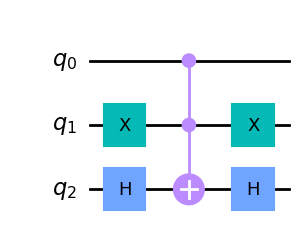

In [71]:
oracle = q.QuantumCircuit(n,name='oracle')
oracle.x(1)
# multiple control Z
oracle.h(n-1)  # H on target qubit
oracle.mcx(list(range(n-1)), n-1)
oracle.h(n-1)  # again H on target qubit
# multiple control Z end
oracle.x(1)

oracle.to_gate()
oracle.draw()

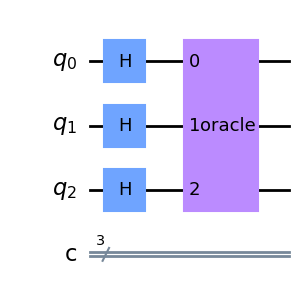

In [72]:
sv_sim = Aer.get_backend('statevector_simulator')
grover_circ = q.QuantumCircuit(n,n,name = 'Grover_Circuit')
grover_circ.h(range(n))
grover_circ.append(oracle,range(n))
grover_circ.draw()

In [73]:
result = q.execute(grover_circ, backend=sv_sim).result()
st_vector = result.get_statevector()
st_vector.draw('latex')

<IPython.core.display.Latex object>

In [82]:
grover_circ.measure([0,1],[0,1])
qasm_sim = Aer.get_backend('qasm_simulator')
result = q.execute(grover_circ,backend=qasm_sim, shots=1000).result()
counts = result.get_counts()
counts

{'010': 250, '000': 243, '001': 267, '011': 240}

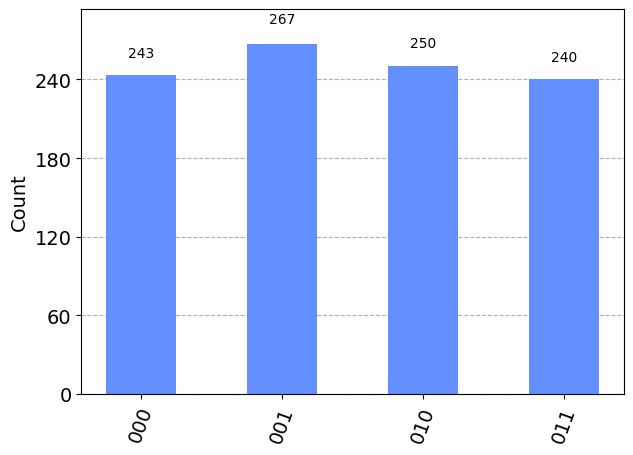

In [83]:
plot_histogram(counts)

#### Making of Reflection Operator 

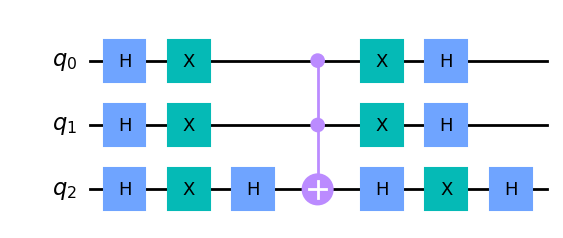

In [84]:
reflection_op = q.QuantumCircuit(n,name="reflection")
reflection_op.h(range(n))
reflection_op.x(range(n))
# reflection_op.z(range(n))
# multiple control Z
reflection_op.h(n-1)  # H on target qubit
reflection_op.mcx(list(range(n-1)), n-1)
reflection_op.h(n-1)  # again H on target qubit
# multiple control Z end
reflection_op.x(range(n))
reflection_op.h(range(n))
reflection_op.to_gate()
reflection_op.draw()

### Grover Circuit

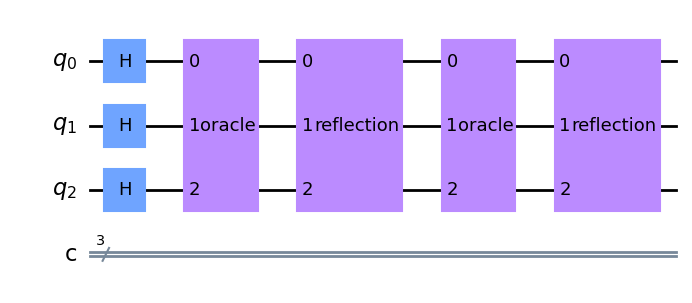

In [89]:
grover_circ2= q.QuantumCircuit(n,n,name = 'Ggrover_Circuit')
grover_circ2.h(range(n))
grover_circ2.append(oracle,range(n))
grover_circ2.append(reflection_op,range(n))
grover_circ2.append(oracle,range(n))
grover_circ2.append(reflection_op,range(n))
grover_circ2.draw()

In [86]:
result = q.execute(grover_circ2,backend=sv_sim).result()
sv = result.get_statevector()
print(sv.draw())
sv.draw('latex')

Statevector([-0.08838835-1.08244507e-16j, -0.08838835-1.62366761e-16j,
             -0.08838835-9.74200563e-17j, -0.08838835-1.29893408e-16j,
             -0.08838835-7.57711549e-17j,  0.97227182+9.09253859e-16j,
             -0.08838835-8.65956056e-17j, -0.08838835-3.24733521e-17j],
            dims=(2, 2, 2))


<IPython.core.display.Latex object>

In [93]:
grover_circ2.measure(range(n),range(n))

In [95]:
qasm_sim = Aer.get_backend('qasm_simulator')
result = q.execute(grover_circ2,qasm_sim,shots = 1000).result()
counts = result.get_counts()
counts

{'111': 2,
 '011': 6,
 '110': 9,
 '010': 8,
 '000': 9,
 '100': 5,
 '001': 6,
 '101': 955}

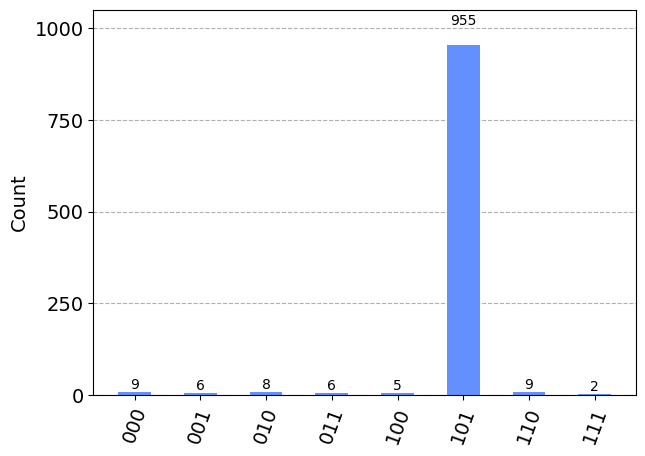

In [96]:
plot_histogram(counts)

## Oraganize all to gether 

In [49]:
from qiskit import quantum_info as qi 
import qiskit as q

In [50]:
import numpy as np
from IPython.display import display as disp

In [51]:
to_bin= (lambda a,size=4 : np.array([int(i) for i in np.binary_repr(a,size)],dtype=int))

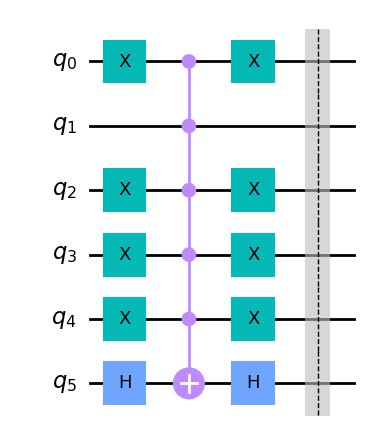

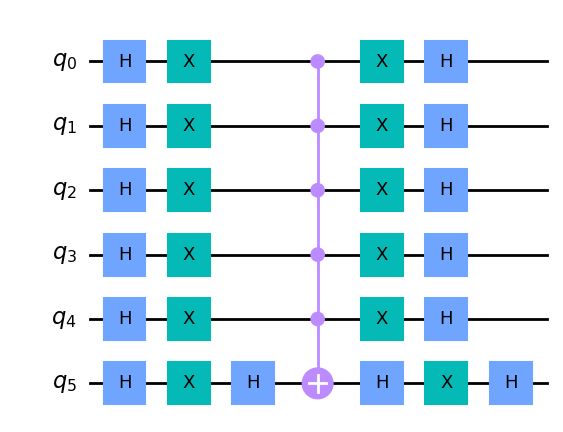

In [100]:
def get_oracle(n:int, target:int)->q.QuantumCircuit:
    ''' n : ceil of log_2(N); where search space is [0:N]
        w : the element to search. [0:2^n]
    '''
    bite_element = np.flip(to_bin(target,n)) 
    circuit = q.QuantumCircuit(n, name="$U_{\omega}$")
    controled0 = np.array([i for i in  range(n) if not bite_element[i]])
    if controled0.size>0:
        circuit.x(controled0)
    circuit.h(n-1)  # H on target qubit
    circuit.mcx(list(range(n-1)), n-1)
    circuit.h(n-1)  # again H on target qubit
    if controled0.size>0:
        circuit.x(controled0)
    circuit.barrier()   
    return circuit

def get_reflection(n)->q.QuantumCircuit: 
    reflection_op = q.QuantumCircuit(n,name="reflection")
    reflection_op.h(range(n))
    reflection_op.x(range(n))
    # reflection_op.z(range(n))
    # multiple control Z
    reflection_op.h(n-1)  # H on target qubit
    reflection_op.mcx(list(range(n-1)), n-1)
    reflection_op.h(n-1)  # again H on target qubit
    # multiple control Z end
    reflection_op.x(range(n))
    reflection_op.h(range(n))
    reflection_op.to_gate()
    return reflection_op
disp(get_oracle(6,34).draw(),get_reflection(6).draw())


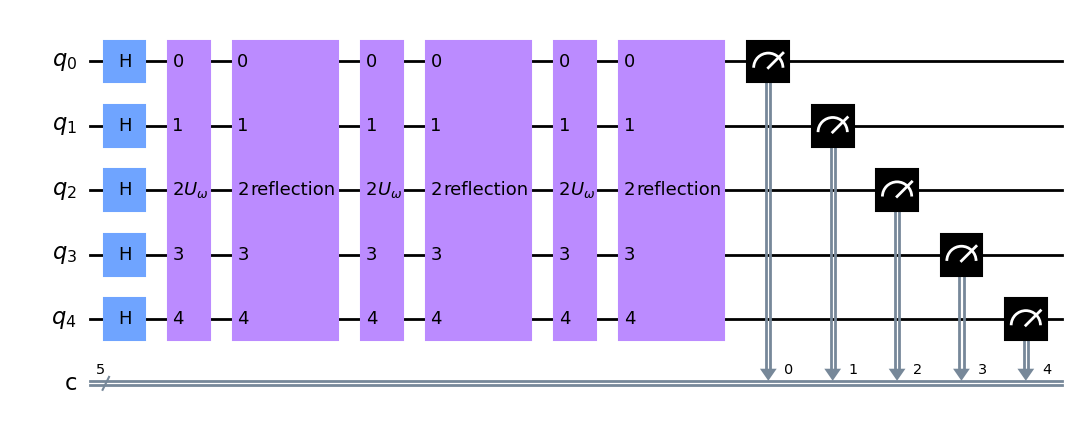

In [106]:
def getGroverCircuit(n:int, target: int)-> q.QuantumCircuit:
    circ = q.QuantumCircuit(n,n, name = 'Grover_Circuit')
    circ.h(range(n))
    circ.append(get_oracle(n,target),range(n))
    circ.append(get_reflection(n),range(n))
    circ.append(get_oracle(n,target),range(n))
    circ.append(get_reflection(n),range(n))
    circ.append(get_oracle(n,target),range(n))
    circ.append(get_reflection(n),range(n))
    circ.measure(range(n),range(n))
    return circ

circ = getGroverCircuit(5,23)
circ.draw()

In [115]:
res = q.execute(circ,backend=qasm_sim,shots = 1).result()
counts = res.get_counts()
counts
desimal_counts={}
for key,value in counts.items():
    desimal_counts[int(key,2)] = value
desimal_counts

{23: 1}

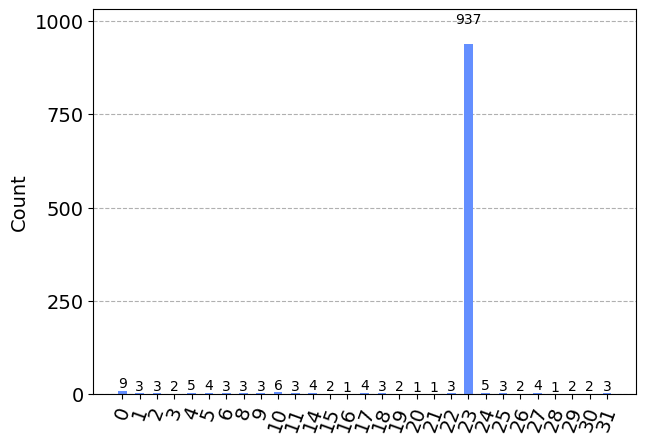

In [113]:
plot_histogram(desimal_counts)